# Python Libraries


In [8]:
#@title Install non-generic libraries
#@markdown vaderSentiment, pyLDAvis
!pip install vaderSentiment
!pip install pyLDAvis

In [9]:
#@title Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import re
import string
import pickle
import time

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('movie_reviews')

#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")

# SpaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Sentiment Analysis
import textblob as tb
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from wordcloud import WordCloud

# Google Colab imports
from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Data

In [11]:
#@title File Upload
#@markdown Fetch all the required files.

#@markdown **reviews.csv**: all available reviews\
#@markdown **items.csv**: all phones available

# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('/content/drive')

reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

Mounted at /content/drive


# Exploratory Data Analysis

## Items Dataset
We have **720 phone models** and **10 features**.  
*rating*, *totalReviews*, *price* and *originalPrice* are **numerical**.  
All other features are **strings**.   

No significant NA's in this dataset.  

**Samsung** has the highest # of phones with 346, followed by **Motorola** having 105 and **Apple** has 63 phones.  

**Xiaomi** has the best rating of 4.4/5 followed by **HUAWEI** and then **ASUS**.

In [12]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [13]:
items.shape

(720, 10)

In [14]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [15]:
item_brand = items.groupby('brand').agg({'asin':['count'], 'rating':['mean'], 'totalReviews':['sum']})
item_brand.columns = ['count_phone', 'avg_rating', 'total_reviews']
item_brand.sort_values(by="count_phone", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Samsung,346,3.632659,37701
Motorola,105,3.643810,9419
Apple,63,3.782540,6315
Xiaomi,46,4.415217,5574
Nokia,44,3.386364,6182
Google,38,3.771053,4238
HUAWEI,32,4.021875,2467
Sony,27,3.788889,3312
OnePlus,10,3.580000,406


In [16]:
item_brand.sort_values(by="avg_rating", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Xiaomi,46,4.415217,5574
HUAWEI,32,4.021875,2467
ASUS,5,3.860000,263
Sony,27,3.788889,3312
Apple,63,3.782540,6315
Google,38,3.771053,4238
Motorola,105,3.643810,9419
Samsung,346,3.632659,37701
OnePlus,10,3.580000,406


## Reviews Dataset
We have **67986 reviews** with **8 features**.  
*rating* and *helpfulVotes* are **numerical**.  
All other features are **strings**.

*helpfulVotes* has a lot of NA's.  
The other features have very few NA's.  

40% of the reviews are for **Samsung**.

In [17]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [18]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [19]:
reviews.shape

(67986, 8)

In [0]:
#reviews.head(2)
#reviews.loc[1,'body']
#tb.TextBlob(reviews.loc[1,'title'])
#tb.TextBlob("Text Messaging Doesn't Work", analyzer=NaiveBayesAnalyzer()).sentiment

## Merged Dataset

The dataset pulled atleast 80% of data available at that time per brand. **Samsung**, **Motorola** and **Nokia** have 90+% data.  

The highest deviation in ratings due to missing reviews is for OnePlus phones at 0.63. **Samsung**, **Motorola**, **Nokia** and **Apple** have less than 0.2 rating deviation.  

We see a bi-modal distribution of ratings for all the brands which is also representative of the plot with all brands combined.  



In [33]:
# Create a merged dataframe
df = pd.merge(reviews, items, on='asin')

# Find brand-wise summary
df_brand = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
df_brand.columns = ['brand', 'reviews', 'avg_avlb_rating']
df_brand = df_brand.sort_values(by='reviews',ascending=False)
brand_summary = pd.merge(df_brand, item_brand, on='brand')
brand_summary['data_ratio'] = brand_summary['reviews']/brand_summary['total_reviews']
brand_summary['rating_dev'] = brand_summary['avg_avlb_rating'] - brand_summary['avg_rating']
brand_summary.to_csv("brand_summary.csv")
brand_rating = pd.pivot_table(df, values='asin', index=['brand'], columns=['rating_x'], aggfunc='count')
brand_rating.to_csv("brand_rating.csv")
# Run this only when you want to overwrite
#!cp brand_rating.csv "drive/My Drive/Amazon_Reviews/"
#!cp brand_summary.csv "drive/My Drive/Amazon_Reviews/"
brand_summary

,brand,reviews,avg_avlb_rating,count_phone,avg_rating,total_reviews,data_ratio,rating_dev
0,Samsung,33629,3.781736,346,3.632659,37701,0.891992,0.149077
1,Motorola,8880,3.818694,105,3.643810,9419,0.942775,0.174884
2,Nokia,5915,3.584446,44,3.386364,6182,0.956810,0.198083
3,Apple,5145,3.701263,63,3.782540,6315,0.814727,-0.081276
4,Xiaomi,4411,4.371344,46,4.415217,5574,0.791353,-0.043873
5,Google,3787,3.584896,38,3.771053,4238,0.893582,-0.186157
6,Sony,3196,3.786921,27,3.788889,3312,0.964976,-0.001968
7,HUAWEI,2225,4.240899,32,4.021875,2467,0.901905,0.219024
8,OnePlus,347,4.213256,10,3.580000,406,0.854680,0.633256
9,ASUS,251,3.721116,5,3.860000,263,0.954373,-0.138884


In [34]:
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,41,23,25,38,124
Apple,1191,243,322,545,2844
Google,883,286,267,435,1916
HUAWEI,246,63,124,268,1524
Motorola,1562,542,653,1310,4813
Nokia,1253,457,540,910,2755
OnePlus,46,6,13,45,237
Samsung,6646,1891,2292,4128,18672
Sony,511,259,280,496,1650


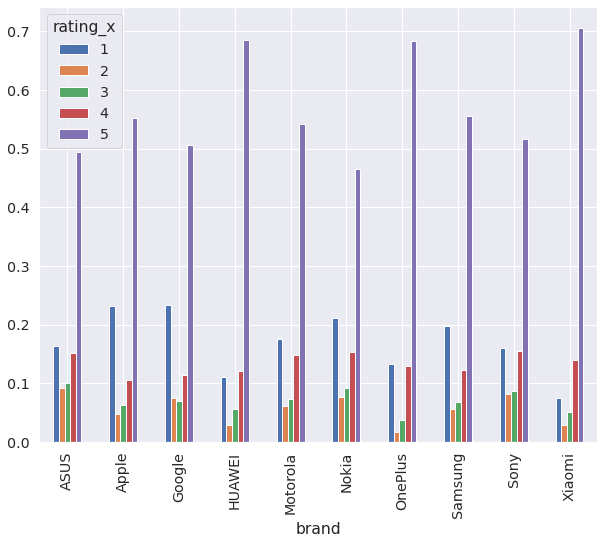

In [28]:
brand_rating = brand_rating.div(brand_rating.sum(axis=1), axis=0)
brand_rating.plot(kind='bar', figsize=(10,8))

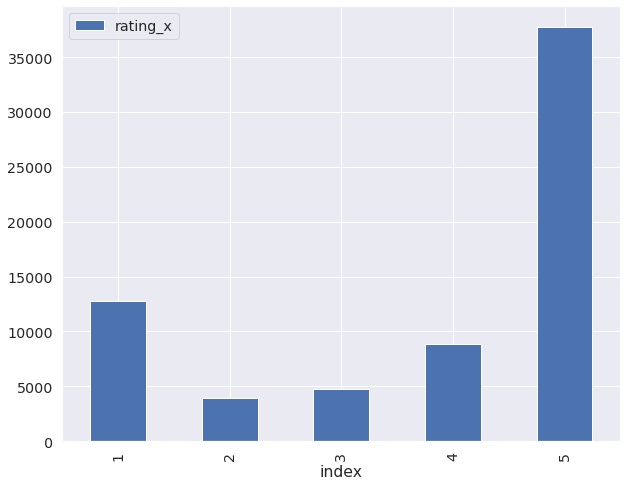

In [29]:
pd.DataFrame(df['rating_x'].value_counts()).reset_index().sort_values(by="index").plot(kind="bar", x="index", figsize=(10,8))

# Sentiment Analysis

def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

In [49]:
#@title Review Data
#@markdown Select the following option if you want to read the file that was already generated to save time. \

pick_from_drive = True #@param {type:"boolean"}
if pick_from_drive:
  file_id = '1-FKpLOlBGNMn8aclDygJ460dIJt-N9Q-'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('reviews.csv')
  df_reviews = pd.read_csv("df_reviews.csv")
  print("File read from drive")
else:
  df_reviews = df[['body', 'brand']].reset_index()
  df_reviews['body'] = df_reviews['body'].fillna("")
  df_reviews['word_count'] = 0
  df_reviews['most_common'] = ""
  df_reviews['common_count'] = 0
  df_reviews['body_clean'] = ""
  stop_words = set(stopwords.words("english"))
  for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub('\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    # store cleaned words
    df_reviews.iloc[i,6] = ' '.join(filtered_rev)

    #Compute number of words
    df_reviews.iloc[i,3] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,5] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,4] = ""
        df_reviews.iloc[i,5] = 0
  df_reviews.head()
  df_reviews.to_csv("df_reviews.csv")
  !cp df_reviews.csv "drive/My Drive/Amazon_Reviews/"
#df_reviews['word_count'].mean()
### example usage ###
#tb.TextBlob("good is good", analyzer=NaiveBayesAnalyzer()).sentiment
#sent = "good bad"
#analyzer = SentimentIntensityAnalyzer()
#analyzer.polarity_scores(sent)['compound']

#df_sent.to_csv("df_sent_0.csv")
#!cp df_sent_0.csv "drive/My Drive/Amazon_Reviews/"

File read from drive


In [54]:
#@title Sentiment Data
#@markdown Select the following option if you want to read the file that was already generated to save time. \
pick_from_drive = True #@param {type:"boolean"}

if pick_from_drive:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_sent_hybrid.csv')
  df_sent = pd.read_csv("df_sent_hybrid.csv")
  print("File read from drive")
else:
  # Create basic template of df for Sentiment Analysis
  df_sent = df_reviews[['body', 'brand', 'rating_x']].reset_index()
  df_sent['sent_tb'] = 0
  df_sent['tb_p'] = 0
  df_sent['tb_n'] = 0
  df_sent['tbnb_p'] = 0
  df_sent['tbnb_n'] = 0
  df_sent['sent_vader'] = 0
  df_sent['vader_p'] = 0
  df_sent['vader_n'] = 0

File read from drive


In [55]:
#@title Simple TextBlob Analyzer
cutoff_sent =  0#@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    #Pick a review
    rev = str(df_sent.iloc[i,1])

    # TextBlob Sentiment Analyzer
    df_sent.iloc[i,4] = tb.TextBlob(rev).sentiment.polarity

    # Pessimistic approach, neutral sentiment => bad review
    if df_sent.iloc[i,4] > cutoff_sent:
      df_sent.iloc[i,5] = 1
    else:
      df_sent.iloc[i,6] = 1

Data picked from drive


In [56]:
#@title TextBlob Analyzer: NaiveBayesAnalyzer
cutoff_sent = 0 #@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    #Pick a review
    rev = str(df_sent.iloc[i,1])

    # TextBlob Sentiment Analyzer with Naive Bayes
    tb_sent_class = tb.TextBlob(rev, analyzer=NaiveBayesAnalyzer()).sentiment.classification

    # TextBlob with Naive Bayes Analyzer
    if tb_sent_class == "pos":
      df_sent.iloc[i,7] = 1
    else:
      df_sent.iloc[i,8] = 1

Data picked from drive


In [57]:
#@title VADER Analyzer
cutoff_sent =  0#@param {type:"number"}

if pick_from_drive:
  print("Data picked from drive")
else:
  for i in range(df_sent.shape[0]):
    # Pick a review
    rev = str(df_sent.iloc[i,1])

    # VADER Sentiment Analyzer
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(rev)
    score = vs['compound']
    df_sent.iloc[i,9] = score
    if df_sent.iloc[i,3] == 5:
      if score > 0.5:
        df_sent.iloc[i,10] = 1
      else:
        df_sent.iloc[i,11] = 1
    else:
      if score >= 0:
        df_sent.iloc[i,10] = 1
      else:
        df_sent.iloc[i,11] = 1
  df_sent.to_csv("df_sent_hybrid.csv")
  !cp df_sent_hybrid.csv "drive/My Drive/Amazon_Reviews/"
  #pd.concat([df_reviews, df['rating_x']], axis=1)

Data picked from drive


In [58]:
#@title Brand-wise Sentiments
review_sentiment = df_sent.groupby('brand').agg({'sent_tb':['mean'], 
                                                 'tb_p':['sum'],
                                                 'tb_n':['sum'],
                                                 'sent_vader':['mean'],
                                                 'vader_p':['sum'],
                                                 'vader_n':['sum']}).reset_index()
review_sentiment.columns = ['brand', 'avg_sent_tb', 'tb_p', 'tb_n', 'avg_sent_vader', 'vader_p', 'vader_n']
review_sentiment

,brand,avg_sent_tb,tb_p,tb_n,avg_sent_vader,vader_p,vader_n
0,ASUS,0,0,0,0.450343,177,74
1,Apple,0,0,0,0.303738,3124,2021
2,Google,0,0,0,0.371158,2549,1238
3,HUAWEI,0,0,0,0.456779,1499,726
4,Motorola,0,0,0,0.405286,6120,2760
5,Nokia,0,0,0,0.373347,4018,1897
6,OnePlus,0,0,0,0.488430,244,103
7,Samsung,0,0,0,0.361681,22199,11430
8,Sony,0,0,0,0.447593,2263,933
9,Xiaomi,0,0,0,0.396646,2592,1819


In [61]:
#@title Classification tables
sentiment = "positive" #@param {type:"string"} ['positive', 'negative']
rating = "1 or 2" #@param {type:"string"} ['1 or 2', '3', '4 or 5']

temp_df = pd.DataFrame()
if sentiment == "positive":
  if rating == "1 or 2":
    temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] < 3)]
  elif rating == "3":
    temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] == 3)]
  else:
    temp_df = df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] > 3)]
else:
  if rating == "1 or 2":
    temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] < 3)]
  elif rating == "3":
    temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] == 3)]
  else:
    temp_df = df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] > 3)]
temp_df

,Unnamed: 0,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
1,1,1,Due to a software issue between Nokia and Spri...,NaN,1,0,0,0,0,0,0.8720,1,0
11,11,11,1.) Slow - If you want to check your missed ca...,NaN,1,0,0,0,0,0,0.5457,1,0
14,14,14,DON'T BUY OUT OF SERVICE,Motorola,1,0,0,0,0,0,0.0000,1,0
22,22,22,I purchased this phone for my AT&T phone repla...,Motorola,1,0,0,0,0,0,0.0000,1,0
23,23,23,The phone did not come with a charger and didn...,Motorola,1,0,0,0,0,0,0.0000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67869,67869,67869,Charger can not connect to the wall outlet,Samsung,2,0,0,0,0,0,0.0000,1,0
67907,67907,67907,This phone isnt worth the price. While it has ...,OnePlus,1,0,0,0,0,0,0.9802,1,0
67935,67935,67935,The Smartphone seems to be OK but no signature...,Sony,1,0,0,0,0,0,0.4618,1,0
67955,67955,67955,"say what you want, Sony makes the best Android...",Sony,2,0,0,0,0,0,0.9614,1,0


# Topic Modeling

Just importing, imputing and cleaning the data again. Not required but for testing purposes

In [0]:
items_df=items.copy()
reviews_df=reviews.copy()
items_df['brand'] = np.where((items_df.asin == 'B0000SX2UC'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B01EWKHIAI'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07JHXX5YR'),'ASUS',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07T3KMJW8'),'Xiaomi',items_df.brand)
merged_data=pd.merge (items_df,reviews_df,how='left',on='asin')
merged_data.shape

KeyError: ignored

In [0]:
merged_data=merged_data.rename(columns={'rating_x': 'Average_Rating','rating_y':'Customer_Rating','title_x':'Product_Name','title_y':'Review_title'})

Cleaning using NLTK

Need to clean the reviews - lower case,remove punctuations and keywords like brand name, phone and finally lemmatize

In [0]:
merged_data["body"] = merged_data["body"].astype("str")
merged_data["clean_text"] = merged_data["body"].apply(clean_text)
merged_data["positivity"] = merged_data["Customer_Rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

Creating an Apple only dataset

In [0]:
merged_data["clean_text"].head().values
apple = merged_data[merged_data["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
apple["renewed"] = apple["Product_Name"].apply(lambda x: ("Renewed" in x) | ("Refurbished" in x))

In [0]:
apple[apple['renewed']==True]
#apple.shape

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity,renewed
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1,True
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1,True
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1,True
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37581,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Greg,5,"April 1, 2019",True,Seems like a great buy,I bought this for my daughter and she seems ve...,NaN,bought daughter pleased use ting service super...,1,True
37616,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Michelle elder,4,"April 1, 2019",True,Gets hot easy.. Kinda worried and honna keep a...,Works with safelink wireless. Put in sim card ...,NaN,work safelink wireless sim card old worked im...,1,True
31785,B06XRJQX91,Apple,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ...",https://www.amazon.com/Apple-iPhone-Unlocked-D...,https://m.media-amazon.com/images/I/61+mrwyL24...,3.6,https://www.amazon.com/product-reviews/B06XRJQX91,427,158.88,271.84,Insiya Hasan,3,"April 1, 2018",True,Three Stars,The phone did have scratches and a dent on it ...,2.0,scratch dent tends overheat,0,True
42977,B077XM1GZM,Apple,"Apple iPhone 6S Plus, 64GB, Silver - Fully Unl...",https://www.amazon.com/Apple-iPhone-a1687-Unlo...,https://m.media-amazon.com/images/I/81ia5dHUn3...,3.8,https://www.amazon.com/product-reviews/B077XM1GZM,12,258.80,349.99,Cheesey,5,"April 1, 2018",True,Quality,Quality refurbished phone. Looks and works lik...,5.0,quality refurbished look work like brand new f...,1,True


Ngrams and Wordclouds


In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(apple["clean_text"], 10)
for word, freq in common_words:
    print(word, freq)



brand new 366
battery life 359
like new 318
sim card 214
work great 176
screen protector 150
perfect condition 117
look like 111
battery health 100
good condition 92


In [0]:
df4 = pd.DataFrame(common_words, columns = ['Bigrams' , 'count'])
df4.head()

,Bigrams,count
0,brand new,366
1,battery life,359
2,like new,318
3,sim card,214
4,work great,176


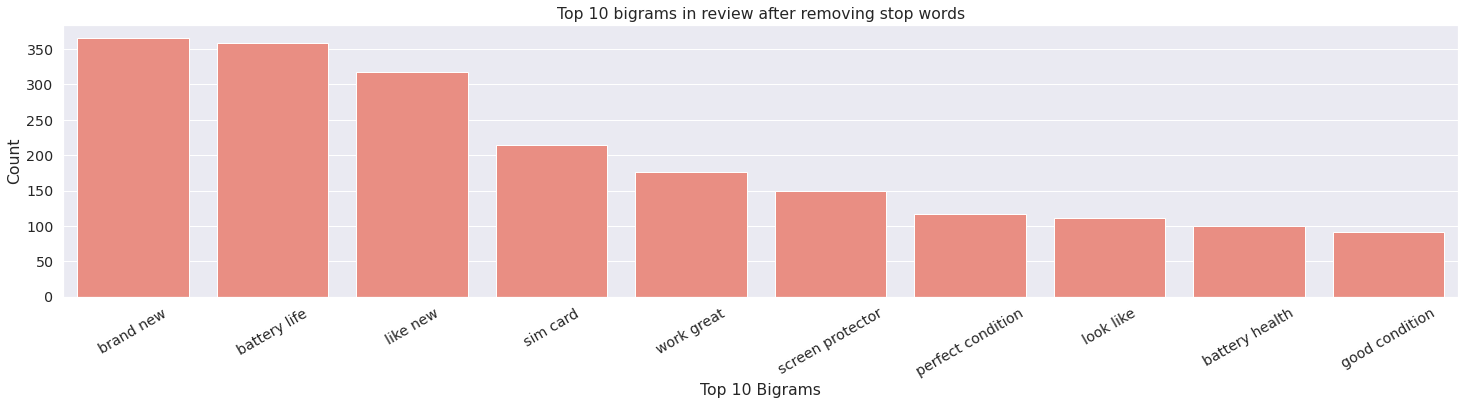

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Bigrams',y='count',data=df4,color="salmon")
plt.xlabel('Top 10 Bigrams')
plt.ylabel('Count')
plt.title('Top 10 bigrams in review after removing stop words')
plt.xticks(rotation=30);


In [0]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigrams = get_top_n_trigram(apple["clean_text"], 10)
for word, freq in common_words_trigrams:
    print(word, freq)

df5 = pd.DataFrame(common_words_trigrams, columns = ['Trigrams' , 'count'])
df5.head()

like brand new 84
look brand new 83
look like new 61
work like new 57
looked brand new 37
came screen protector 35
like new condition 26
brand new scratch 23
came perfect condition 23
glass screen protector 21


,Trigrams,count
0,like brand new,84
1,look brand new,83
2,look like new,61
3,work like new,57
4,looked brand new,37


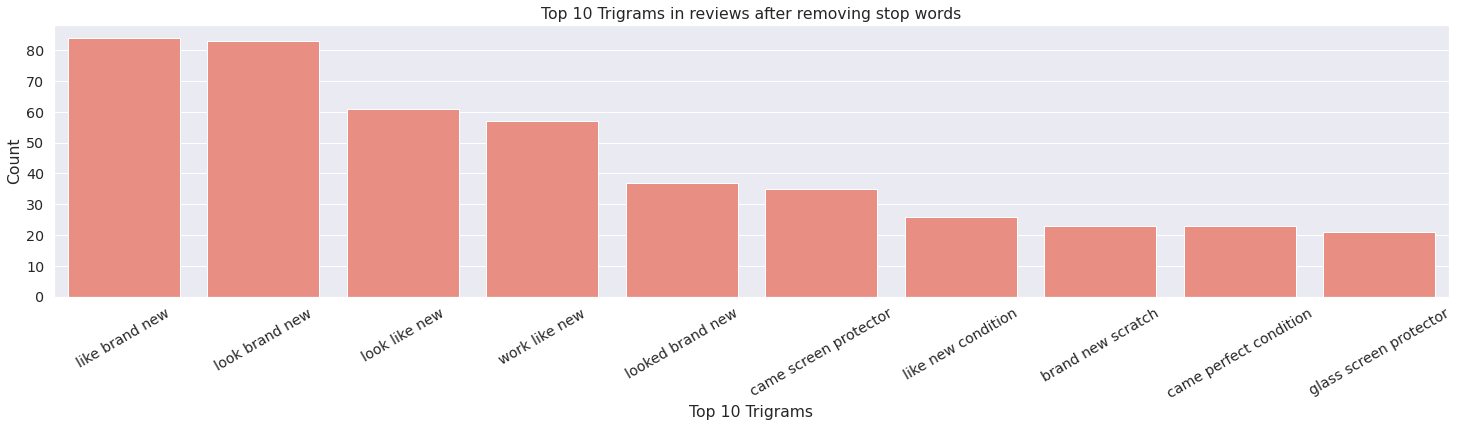

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Trigrams',y='count',data=df5,color="salmon")
plt.xlabel('Top 10 Trigrams')
plt.ylabel('Count')
plt.title('Top 10 Trigrams in reviews after removing stop words')
plt.xticks(rotation=30);

In [0]:
from wordcloud import WordCloud, ImageColorGenerator

# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [0]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

In [0]:
#@title Import data for Topic Modeling
file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('df_sent_hybrid.csv')
topic_df = pd.read_csv("df_sent_hybrid.csv")
topic_df['brand'] = topic_df['brand'].astype(str)

print("Data import complete!")

Data import complete!


In [0]:
#@title Apple, Samsung and Xiaomi subsets
topic_df_Apple=topic_df[topic_df['brand']=='Apple']
topic_df_Apple['body']=topic_df_Apple['body'].astype(str)
apple_pos = topic_df_Apple[topic_df_Apple['vader_p']==1]
apple_neg = topic_df_Apple[topic_df_Apple['vader_n']==1]

topic_df_Samsung=topic_df[topic_df['brand']=='Samsung']
topic_df_Samsung['body']=topic_df_Samsung['body'].astype(str)
samsung_pos = topic_df_Samsung[topic_df_Samsung['vader_p']==1]
samsung_neg = topic_df_Samsung[topic_df_Samsung['vader_n']==1]

topic_df_Xiaomi=topic_df[topic_df['brand']=='Xiaomi']
topic_df_Xiaomi['body']=topic_df_Xiaomi['body'].astype(str)
xiaomi_pos = topic_df_Xiaomi[topic_df_Xiaomi['vader_p']==1]
xiaomi_neg = topic_df_Xiaomi[topic_df_Xiaomi['vader_n']==1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [0]:
#@title Clean data for Topic Modeling
keywords = topic_df["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
lemma = WordNetLemmatizer()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)

apple_neg['clean_text'] = ""
apple_neg["clean_text"] = apple_neg["body"].apply(clean_text)
cv = CountVectorizer(ngram_range=(2,3),
                     stop_words='english')
dtm = cv.fit_transform(apple_neg['clean_text'])
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [0]:
#dtm = cv.fit_transform(topic_df["body"])
#common_words_bigrams = get_top_n_bigram(topic_df_Apple_neg['body'])
#bigrams_list = [a_tuple[0] for a_tuple in common_words_bigrams]

In [0]:
#@title LDA
n_topics=10
lda = LatentDirichletAllocation(
      n_components=n_topics, 
      max_iter=100, 
      learning_method='online',
      learning_offset=100.0,
      n_jobs=1,
      random_state=0,learning_decay=0.5)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=100.0,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=10, n_jobs=1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [0]:
single_topic = lda.components_[0]
top_words = single_topic.argsort()[-15:]
for index in top_words:
  #print(tfidf_vectorizer.get_feature_names()[index])
  print(cv.get_feature_names()[index])

work look like
fully unlocked
battery health
work great
new scratch
work look
new battery
look like new
like brand
like brand new
like new
look brand new
look brand
look like
brand new


In [0]:
for i,topic in enumerate(lda.components_):
  print(f"Top Words for topic #{i}")
  print([cv.get_feature_names()[index] for index in topic.argsort()[-15:]])
  #print('\n')

Top Words for topic #0
['work look like', 'fully unlocked', 'battery health', 'work great', 'new scratch', 'work look', 'new battery', 'look like new', 'like brand', 'like brand new', 'like new', 'look brand new', 'look brand', 'look like', 'brand new']
Top Words for topic #1
['new battery', '100 battery', '100 battery health', 'new condition', 'like new condition', 'home button', 'doesn work', 'waste money', 'el celular', 'work like new', 'screen protector', 'battery life', 'work like', 'battery health', 'like new']
Top Words for topic #2
['unsupported browser', 'video unsupported browser', 'video unsupported', 'negative review', 'original box', 'service plan', 'verizon sim', 'exactly described', 'reading review', 'came screen protector', 'came screen', 'look new', 'screen protector', 'work fine', 'sim card']
Top Words for topic #3
['came fully unlocked', 'look like', 'battery 100', 'minor scratch', 'looked new', 'like new', 'el teléfono', 'worth money', 'screen protector', '64 gb', '

## Non Negative Matrix Factorization 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
tfidf= TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english',ngram_range=(3,3))

In [0]:
dtm = tfidf.fit_transform(topic_df_Apple_neg['clean_text'])

In [0]:
nmf_model=NMF(n_components=n_topics,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=4, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [0]:
for index,topic in enumerate(nmf_model.components_):
  print(f"THE TOP 10 WORDS FOR TOPIC #{index}")
  print([tfidf.get_feature_names()[index] for index in topic.argsort()[-10:]])
  #print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['sim card worked', 'new scratch dent', 'camera shutter sound', 'brand new battery', 'brand new far', 'came sooner expected', 'looked like new', 'scratch look brand', 'brand new scratch', 'look brand new']
THE TOP 10 WORDS FOR TOPIC #1
['issue far week', 'came generic charger', 'far week cosmetic', 'renewed work like', 'generic charger issue', 'week cosmetic damage', 'new came generic', 'like new came', 'look work like', 'work like new']
THE TOP 10 WORDS FOR TOPIC #2
['new prefect came', 'brand new prefect', 'prefect came fully', 'came fully unlocked', 'work look like', 'battery life good', 'worked like brand', 'look like brand', 'work like brand', 'like brand new']
THE TOP 10 WORDS FOR TOPIC #3
['screen protector charger', 'camera shutter sound', 'condition battery life', 'quality battery life', 'came screen protector', 'new scratch dent', 'brand new scratch', 'battery life good', 'charger head phone', 'looked brand new']


## USING GENSIM

In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['phone','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

# Convert to list
data = apple_neg.body.values.tolist()
data_words = list(sent_to_words(data))

In [0]:
keywords = topic_df["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
keywords.append("ipad")
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]   
    # Remove other keywords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in keywords] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words) 

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
process_words(['This is a sample sentence. Lets see if this removes ipad and iphone and phones from this text !!!'])

[['let', 'remove', 'text']]

In [0]:
#@title Default title text
num_topics =  4#@param {type:"integer"}
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency using BOW model
corpus = [id2word.doc2bow(text) for text in data_ready]


#Using Tfidf - replace corpus with corpus_tfidf
from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#corpus = [id2word.doc2bow(text) for text in data_ready]
# Build LDA model
#Nmf(corpus_tfidf, num_topics=50, kappa=0.1, eval_every=5) #NMF
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(4)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6333,"reset, bad, recommend, hard, minute, condition, product, allow, price, seller","[purchase, refurbish, air, late, update, crash, minute, operation, sync, multiple, time, fix, of..."
1,1,1.0,0.4063,"reset, bad, recommend, hard, minute, condition, product, allow, price, seller","[sims_card, assume, always, build, wrong, information, description, produce, mislead, clearly, s..."
2,2,3.0,0.5822,"new, turn, plug, scratch, work, set, screen, battery, buy, problem","[ever, buy, refurbish, product, buy, th, generation, life, start, degrade, week, less, gym, batt..."
3,3,1.0,0.4295,"reset, bad, recommend, hard, minute, condition, product, allow, price, seller","[great, product, headphone, include, seller, ignore, email]"


In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9659,"item, cable, sin, well, terrible, phonr, hora, incorrect, like, audifono","[reside, vendedor, dice, vendedor, este, vendedor, por, este, vendedor, sin, operadore, con, pla..."
1,1.0,0.9421,"reset, bad, recommend, hard, minute, condition, product, allow, price, seller","[water, resistance, rating, pure, garbage, drown, inch, water, minute, class, action, lawsuit]"
2,2.0,0.9259,"describe, expect, headphone, photo, miss, telfone, performance, minor, peak, tray","[ole, pwm, pulse, width, modulation, cause, headache, eye, strain, fingerprint, sensor, become, ..."
3,3.0,0.9697,"new, turn, plug, scratch, work, set, screen, battery, buy, problem","[refurb, replacement, screen, battery, health, body, small, bottom, corner, paint, match, unnoti..."


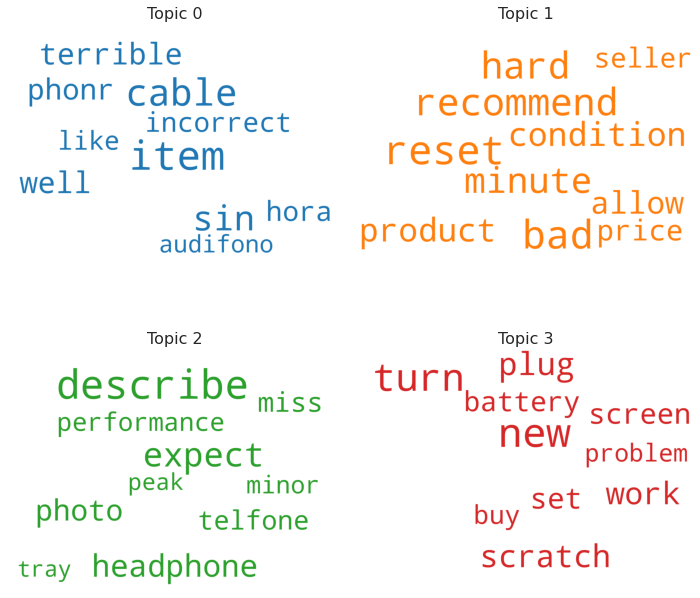

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

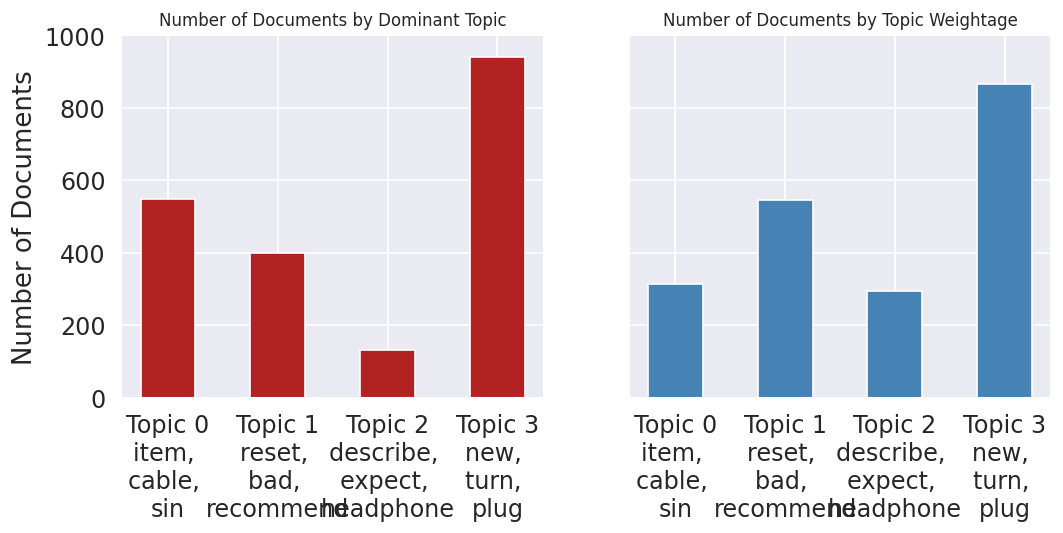

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.210409 -0.074851       1        1  53.339325
1     -0.155384 -0.139457       2        1  31.448915
2     -0.024410  0.103280       3        1   8.168856
0     -0.030615  0.111027       4        1   7.042898, topic_info=                Term        Freq       Total Category  logprob  loglift
69               new  296.000000  296.000000  Default  30.0000  30.0000
392            reset  153.000000  153.000000  Default  29.0000  29.0000
214              bad  146.000000  146.000000  Default  28.0000  28.0000
120             turn  269.000000  269.000000  Default  27.0000  27.0000
391        recommend  137.000000  137.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2190         seeping    5.514132    9.599075   Topic4  -5.3901   2.0988
2191        simulate    5.514132    9.599075   Topic4  -5.3901   2.0988
928   intermittently    5.211679    9.169491   Topic4  -5.4465   2.0882
1033         running    5.211620    9.169544   Topic4  -5.4465   2.0882
2186           tempt    5.335569   14.966669   Topic4  -5.4230   1.6217

[170 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1489      1  0.095473   adapter
1489      2  0.095473   adapter
1489      3  0.763781   adapter
2188      1  0.208353  adhesive
2188      2  0.208353  adhesive
...     ...       ...       ...
144       4  0.893839      well
663       1  0.071416      wifi
663       2  0.928413      wifi
121       1  0.990050      work
121       2  0.005893      work

[367 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [0]:
# To find number of topics - using coherence measure

In [0]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

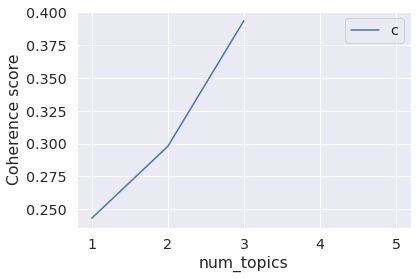

In [0]:
lmlist, c_v = evaluate_graph(dictionary=id2word, corpus=corpus, texts=data_words, limit=10)